In [3]:
import torch
from transformers import AutoTokenizer, AutoModelForSequenceClassification, TrainingArguments, Trainer, TrainerCallback
from datasets import Dataset
from sklearn.metrics import accuracy_score, precision_recall_fscore_support, confusion_matrix 
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from torch import nn
import seaborn as sns
import time
import psutil
import json
from adapters import AutoAdapterModel, AdapterConfig, AdapterTrainer
from peft import get_peft_model, LoraConfig, TaskType, PeftModel, PeftConfig, PrefixTuningConfig

'NoneType' object has no attribute 'cadam32bit_grad_fp32'


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/bitsandbytes/cextension.py:34: UserWarning: The installed version of bitsandbytes was compiled without GPU support. 8-bit optimizers, 8-bit multiplication, and GPU quantization are unavailable.
  warn("The installed version of bitsandbytes was compiled without GPU support. "


#  1. Helper Functions and Common Setup

In [4]:
def tokenize_function(examples):
    return tokenizer(examples["text"], truncation=True, padding="max_length", max_length=128)

In [5]:
def load_and_preprocess_data(file_path):
    df = pd.read_csv(file_path)
    dataset = Dataset.from_pandas(df)
    tokenized_dataset = dataset.map(tokenize_function, batched=True, remove_columns=["text"])
    tokenized_dataset = tokenized_dataset.rename_column("label", "labels")
    return tokenized_dataset

In [6]:
def compute_metrics(eval_pred):
    logits, labels = eval_pred
    predictions = np.argmax(logits, axis=-1)
    precision, recall, f1, _ = precision_recall_fscore_support(labels, predictions, average='weighted')
    acc = accuracy_score(labels, predictions)
    return {
        'accuracy': acc,
        'f1': f1,
        'precision': precision,
        'recall': recall,
    }

In [7]:
class MetricsCallback(TrainerCallback):
    def __init__(self):
        self.train_losses = []
        self.eval_losses = []
        self.eval_metrics = []
        self.lr_schedule = []

    def on_log(self, args, state, control, logs=None, **kwargs):
        if logs is not None:
            if 'loss' in logs:
                self.train_losses.append(logs['loss'])
            if 'eval_loss' in logs:
                self.eval_losses.append(logs['eval_loss'])
            if 'eval_accuracy' in logs:
                self.eval_metrics.append(logs)
            if 'learning_rate' in logs:
                self.lr_schedule.append(logs['learning_rate'])

metrics_callback_baseline = MetricsCallback()
metrics_callback_adapter = MetricsCallback()
metrics_callback_lora = MetricsCallback()
metrics_callback_prefix = MetricsCallback()

In [8]:
class ResourceMonitor(TrainerCallback):
    def __init__(self):
        self.cpu_usage = []
        self.memory_usage = []
        self.gpu_memory_usage = []
        self.start_time = None
        self.end_time = None

    def on_train_begin(self, args, state, control, **kwargs):
        self.start_time = time.time()

    def on_train_end(self, args, state, control, **kwargs):
        self.end_time = time.time()

    def on_step_end(self, args, state, control, **kwargs):
        self.cpu_usage.append(psutil.cpu_percent())
        memory = psutil.virtual_memory()
        self.memory_usage.append(memory.percent)
        if torch.cuda.is_available():
            gpu_memory = torch.cuda.memory_allocated() / torch.cuda.max_memory_allocated()
            self.gpu_memory_usage.append(gpu_memory * 100)

    def get_summary(self):
        total_time = self.end_time - self.start_time
        return {
            "total_time": total_time,
            "avg_cpu_usage": sum(self.cpu_usage) / len(self.cpu_usage),
            "max_cpu_usage": max(self.cpu_usage),
            "avg_memory_usage": sum(self.memory_usage) / len(self.memory_usage),
            "max_memory_usage": max(self.memory_usage),
            "avg_gpu_memory_usage": sum(self.gpu_memory_usage) / len(self.gpu_memory_usage) if self.gpu_memory_usage else None,
            "max_gpu_memory_usage": max(self.gpu_memory_usage) if self.gpu_memory_usage else None,
        }

resource_monitor_baseline = ResourceMonitor()
resource_monitor_adapter = ResourceMonitor()
resource_monitor_lora = ResourceMonitor()
resource_monitor_prefix = ResourceMonitor()

# 2. Plotting Functions

In [21]:
def plot_learning_rate_schedule(lr_schedules, labels):
    plt.figure(figsize=(10, 5))
    colors = ['blue', 'orange', 'green', 'red']  # Define colors for each line
    for lr_schedule, label, color in zip(lr_schedules, labels, colors):
        if len(lr_schedule) > 0:  # Check if the schedule has data
            plt.plot(lr_schedule, label=label, color=color)
        else:
            print(f"No data for {label}'s learning rate schedule.")
    plt.title('Learning Rate Schedule')
    plt.xlabel('Training Steps')
    plt.ylabel('Learning Rate')
    plt.legend()
    plt.savefig('learning_rate_curve.png')
    plt.show()

In [22]:
def plot_loss_curves(train_losses, eval_losses, labels):
    plt.figure(figsize=(10, 5))
    for train_loss, eval_loss, label in zip(train_losses, eval_losses, labels):
        plt.plot(train_loss, label=f'Training Loss - {label}')
        plt.plot(np.linspace(0, len(train_loss), len(eval_loss)), eval_loss, label=f'Validation Loss - {label}')
    plt.title('Training and Validation Loss')
    plt.xlabel('Training Steps')
    plt.ylabel('Loss')
    plt.legend()
    plt.savefig('loss_curves.png')
    plt.show()

In [23]:
def plot_evaluation_metrics(eval_metrics_list, labels):
    metrics = ['accuracy', 'f1', 'precision', 'recall']
    plt.figure(figsize=(12, 8))
    for eval_metrics, label in zip(eval_metrics_list, labels):
        for metric in metrics:
            values = [log[f'eval_{metric}'] for log in eval_metrics]
            plt.plot(values, label=f'{metric.capitalize()} - {label}')
    plt.title('Evaluation Metrics')
    plt.xlabel('Evaluation Steps')
    plt.ylabel('Score')
    plt.legend()
    plt.savefig('evaluation_metrics.png')
    plt.show()

In [24]:
def plot_confusion_matrix(y_true_list, y_pred_list, labels):
    for y_true, y_pred, label in zip(y_true_list, y_pred_list, labels):
        cm = confusion_matrix(y_true, y_pred)
        plt.figure(figsize=(10, 8))
        sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
        plt.title(f'Confusion Matrix - {label}')
        plt.ylabel('True Label')
        plt.xlabel('Predicted Label')
        plt.savefig(f'confusion_matrix_{label}.png')
        plt.show()

# 3. Baseline Model Fine-Tuning

In [13]:
model_name = "ProsusAI/finbert"
tokenizer = AutoTokenizer.from_pretrained(model_name)
model_baseline = AutoModelForSequenceClassification.from_pretrained(model_name, num_labels=3)

if tokenizer.pad_token is None:
    tokenizer.pad_token = tokenizer.eos_token
    model_baseline.config.pad_token_id = model_baseline.config.eos_token_id

train_dataset = load_and_preprocess_data("/Users/yaseminsilen/Downloads/FPB_training_set_final.csv")
val_dataset = load_and_preprocess_data("/Users/yaseminsilen/Downloads/FPB_validation_set_final.csv")

class_weights = torch.tensor([1.2, 1.2, 1.0], dtype=torch.float)
device = torch.device("cuda" if torch.cuda.is_available() else ("mps" if torch.backends.mps.is_available() else "cpu"))
class_weights = class_weights.to(device)

/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/torch/_utils.py:776: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  return self.fget.__get__(instance, owner)()


Map:   0%|          | 0/3392 [00:00<?, ? examples/s]

Map:   0%|          | 0/1454 [00:00<?, ? examples/s]

In [14]:
training_args_baseline = TrainingArguments(
    output_dir="./finbert_finance_sentiment_baseline",
    overwrite_output_dir=True,
    num_train_epochs=5,
    per_device_train_batch_size=8,
    per_device_eval_batch_size=8,
    evaluation_strategy="steps",
    eval_steps=100,
    save_strategy="steps",
    save_steps=100,
    save_total_limit=2,
    load_best_model_at_end=True,
    learning_rate=2e-5,
    weight_decay=0.01,
    metric_for_best_model="accuracy",
    logging_dir='./logs',
    logging_steps=100,
    warmup_steps=100,
    fp16=torch.cuda.is_available(),
    gradient_accumulation_steps=2,
)

In [15]:
class WeightedLossTrainer(Trainer):
    def __init__(self, class_weights, *args, **kwargs):
        super().__init__(*args, **kwargs)
        self.class_weights = class_weights

    def compute_loss(self, model, inputs, return_outputs=False):
        labels = inputs.pop("labels")
        outputs = model(**inputs)
        logits = outputs.logits
        loss_fct = nn.CrossEntropyLoss(weight=self.class_weights)
        loss = loss_fct(logits.view(-1, self.model.config.num_labels), labels.view(-1))
        return (loss, outputs) if return_outputs else loss

In [16]:
trainer_baseline = WeightedLossTrainer(
    class_weights=class_weights,
    model=model_baseline,
    args=training_args_baseline,
    train_dataset=train_dataset,
    eval_dataset=val_dataset,
    compute_metrics=compute_metrics,
    callbacks=[metrics_callback_baseline, resource_monitor_baseline],
)

trainer_baseline.train()
trainer_baseline.save_model("./finbert_finance_sentiment_baseline")

resource_summary_baseline = resource_monitor_baseline.get_summary()
device = "cuda" if torch.cuda.is_available() else ("mps" if torch.backends.mps.is_available() else "cpu")
model_baseline = AutoModelForSequenceClassification.from_pretrained("./finbert_finance_sentiment_baseline").to(device)

Step,Training Loss,Validation Loss,Accuracy,F1,Precision,Recall
100,1.308600,0.742829,0.638239,0.619038,0.612138,0.638239
200,0.641100,0.488207,0.814993,0.815848,0.817044,0.814993
300,0.446600,0.475360,0.816369,0.809119,0.821803,0.816369
400,0.417500,0.445565,0.818432,0.820617,0.826152,0.818432
500,0.276800,0.450364,0.837689,0.837052,0.836803,0.837689
600,0.238400,0.476159,0.824622,0.822204,0.825693,0.824622
700,0.139100,0.548281,0.833563,0.835192,0.839040,0.833563
800,0.137900,0.575692,0.834938,0.834073,0.836493,0.834938
900,0.109200,0.579485,0.829436,0.829601,0.830537,0.829436
1000,0.079900,0.611075,0.830812,0.831099,0.832326,0.830812


In [17]:
def predict_sentiment(text, model):
    inputs = tokenizer(text, return_tensors="pt", truncation=True, padding=True, max_length=128).to(device)
    with torch.no_grad():
        outputs = model(**inputs)
    probabilities = torch.nn.functional.softmax(outputs.logits, dim=-1)
    predicted_class = torch.argmax(probabilities, dim=-1).item()
    sentiment_map = {0: "Negative", 1: "Neutral", 2: "Positive"}
    return sentiment_map[predicted_class]

val_predictions_baseline = trainer_baseline.predict(val_dataset)
y_true_baseline = val_predictions_baseline.label_ids
y_pred_baseline = np.argmax(val_predictions_baseline.predictions, axis=1)
final_metrics_baseline = compute_metrics((val_predictions_baseline.predictions, y_true_baseline))

# 4. Adapter Fine-Tuning

In [26]:
model_adapter = AutoAdapterModel.from_pretrained(model_name)
adapter_config = AdapterConfig.load("pfeiffer", reduction_factor=16)
model_adapter.add_adapter("financial_sentiment", config=adapter_config)
model_adapter.add_classification_head("financial_sentiment", num_labels=3)
model_adapter.train_adapter("financial_sentiment")

In [19]:
training_args_adapter = TrainingArguments(
    output_dir="./finbert_finance_sentiment_adapter",
    overwrite_output_dir=True,
    num_train_epochs=5,
    per_device_train_batch_size=8,
    per_device_eval_batch_size=8,
    evaluation_strategy="steps",
    eval_steps=100,
    save_strategy="steps",
    save_steps=100,
    save_total_limit=2,
    load_best_model_at_end=True,
    learning_rate=2e-4,
    weight_decay=0.01,
    metric_for_best_model="accuracy",
    logging_dir='./logs',
    logging_steps=100,
    warmup_steps=300,
    fp16=torch.cuda.is_available(),
    gradient_accumulation_steps=2,
)

In [27]:
class WeightedLossAdapterTrainer(AdapterTrainer):
    def __init__(self, class_weights, *args, **kwargs):
        super().__init__(*args, **kwargs)
        self.class_weights = class_weights

    def compute_loss(self, model, inputs, return_outputs=False):
        labels = inputs.pop("labels")
        outputs = model(**inputs)
        logits = outputs.logits
        loss_fct = nn.CrossEntropyLoss(weight=self.class_weights)
        loss = loss_fct(logits.view(-1, self.model.config.num_labels), labels.view(-1))
        return (loss, outputs) if return_outputs else loss

In [28]:
trainer_adapter = WeightedLossAdapterTrainer(
    class_weights=class_weights,
    model=model_adapter,
    args=training_args_adapter,
    train_dataset=train_dataset,
    eval_dataset=val_dataset,
    compute_metrics=compute_metrics,
    callbacks=[metrics_callback_adapter, resource_monitor_adapter],
)

trainer_adapter.train()

Step,Training Loss,Validation Loss,Accuracy,F1,Precision,Recall
100,0.742700,0.468367,0.796424,0.789804,0.796236,0.796424
200,0.500900,0.436429,0.824622,0.823664,0.823287,0.824622
300,0.455800,0.462674,0.819120,0.810074,0.827958,0.819120
400,0.454200,0.420955,0.828748,0.829509,0.830725,0.828748
500,0.389400,0.412036,0.833563,0.832093,0.832889,0.833563
600,0.388700,0.432696,0.828061,0.827498,0.832733,0.828061
700,0.336300,0.419767,0.837001,0.838210,0.840628,0.837001
800,0.331000,0.429372,0.834250,0.834982,0.838165,0.834250
900,0.290300,0.423401,0.839065,0.837894,0.838757,0.839065
1000,0.273400,0.419467,0.841816,0.840831,0.840768,0.841816


Overwriting existing adapter 'financial_sentiment'.
Overwriting existing head 'financial_sentiment'


TrainOutput(global_step=1060, training_loss=0.4085277557373047, metrics={'train_runtime': 1712.8374, 'train_samples_per_second': 9.902, 'train_steps_per_second': 0.619, 'total_flos': 1134975044321280.0, 'train_loss': 0.4085277557373047, 'epoch': 5.0})

In [29]:
model_adapter.save_adapter("./finbert_finance_sentiment_adapter", "financial_sentiment")
model_adapter.save_head("./finbert_finance_sentiment_adapter", "financial_sentiment")


resource_summary_adapter = resource_monitor_adapter.get_summary()

val_predictions_adapter = trainer_adapter.predict(val_dataset)
y_true_adapter = val_predictions_adapter.label_ids
y_pred_adapter = np.argmax(val_predictions_adapter.predictions, axis=1)
final_metrics_adapter = compute_metrics((val_predictions_adapter.predictions, y_true_adapter))

# 5. LoRA Fine-Tuning

In [30]:
model_lora = AutoModelForSequenceClassification.from_pretrained(model_name, num_labels=3)
peft_config = LoraConfig(
    task_type=TaskType.SEQ_CLS,
    r=8,
    lora_alpha=16,
    lora_dropout=0.1,
    target_modules=["query", "key", "value"],
    modules_to_save=["classifier"]
)
model_lora = get_peft_model(model_lora, peft_config)
model_lora.print_trainable_parameters()

/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


trainable params: 444,675 || all params: 109,929,222 || trainable%: 0.4045


In [31]:
training_args_lora = TrainingArguments(
    output_dir="./finbert_finance_sentiment_lora",
    overwrite_output_dir=True,
    num_train_epochs=5,
    per_device_train_batch_size=8,
    per_device_eval_batch_size=8,
    evaluation_strategy="steps",
    eval_steps=100,
    save_strategy="steps",
    save_steps=100,
    save_total_limit=2,
    load_best_model_at_end=True,
    learning_rate=2e-4,
    weight_decay=0.01,
    metric_for_best_model="accuracy",
    logging_dir='./logs',
    logging_steps=100,
    warmup_steps=100,
    fp16=torch.cuda.is_available(),
    gradient_accumulation_steps=2,
)

In [32]:
trainer_lora = WeightedLossTrainer(
    class_weights=class_weights,
    model=model_lora,
    args=training_args_lora,
    train_dataset=train_dataset,
    eval_dataset=val_dataset,
    compute_metrics=compute_metrics,
    callbacks=[metrics_callback_lora, resource_monitor_lora],
)

trainer_lora.train()
trainer_lora.model.save_pretrained("./finbert_finance_sentiment_lora")

Step,Training Loss,Validation Loss,Accuracy,F1,Precision,Recall
100,1.665700,0.589495,0.744154,0.717514,0.767810,0.744154
200,0.509200,0.442742,0.818432,0.816921,0.817232,0.818432
300,0.435200,0.422794,0.829436,0.827922,0.828088,0.829436
400,0.449100,0.419536,0.831499,0.831816,0.832650,0.831499
500,0.401400,0.405954,0.836314,0.832749,0.835589,0.836314
600,0.385700,0.408955,0.841128,0.840264,0.840713,0.841128
700,0.353600,0.408309,0.845254,0.844973,0.844757,0.845254
800,0.381600,0.400261,0.839065,0.837485,0.837437,0.839065
900,0.353500,0.399260,0.839065,0.837656,0.837679,0.839065
1000,0.329700,0.405237,0.838377,0.838147,0.837996,0.838377


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
/Library/Frameworks/Python.f

In [33]:
resource_summary_lora = resource_monitor_lora.get_summary()
config = PeftConfig.from_pretrained("./finbert_finance_sentiment_lora")
model_lora = AutoModelForSequenceClassification.from_pretrained(config.base_model_name_or_path, num_labels=3)
model_lora = PeftModel.from_pretrained(model_lora, "./finbert_finance_sentiment_lora")
model_lora.to(device)

val_predictions_lora = trainer_lora.predict(val_dataset)
y_true_lora = val_predictions_lora.label_ids
y_pred_lora = np.argmax(val_predictions_lora.predictions, axis=1)
final_metrics_lora = compute_metrics((val_predictions_lora.predictions, y_true_lora))

# 6. Prefix Fine-Tuning

In [35]:
model_prefix = AutoModelForSequenceClassification.from_pretrained(model_name, num_labels=3)
peft_config = PrefixTuningConfig(
    task_type=TaskType.SEQ_CLS,
    num_virtual_tokens=10,
    prefix_projection=True,
    encoder_hidden_size=model_prefix.config.hidden_size
)
model_prefix = get_peft_model(model_prefix, peft_config)
model_prefix.print_trainable_parameters()

/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


trainable params: 14,774,787 || all params: 124,259,334 || trainable%: 11.8903


In [36]:
training_args_prefix = TrainingArguments(
    output_dir="./finbert_finance_sentiment_prefix",
    overwrite_output_dir=True,
    num_train_epochs=5,
    per_device_train_batch_size=8,
    per_device_eval_batch_size=8,
    evaluation_strategy="steps",
    eval_steps=100,
    save_strategy="steps",
    save_steps=100,
    save_total_limit=2,
    load_best_model_at_end=False,
    learning_rate=2e-4,
    weight_decay=0.01,
    metric_for_best_model="accuracy",
    logging_dir='./logs',
    logging_steps=100,
    warmup_steps=300,
    fp16=torch.cuda.is_available(),
    gradient_accumulation_steps=2,
)

In [37]:
trainer_prefix = WeightedLossTrainer(
    class_weights=class_weights,
    model=model_prefix,
    args=training_args_prefix,
    train_dataset=train_dataset,
    eval_dataset=val_dataset,
    compute_metrics=compute_metrics,
    callbacks=[metrics_callback_prefix, resource_monitor_prefix],
)

trainer_prefix.train()
trainer_prefix.model.save_pretrained("./finbert_finance_sentiment_prefix")

Step,Training Loss,Validation Loss,Accuracy,F1,Precision,Recall
100,1.611300,0.896316,0.582531,0.428860,0.339342,0.582531
200,0.816200,0.679759,0.688446,0.654190,0.659377,0.688446
300,0.649500,0.598962,0.761348,0.742009,0.758705,0.761348
400,0.598800,0.492737,0.805365,0.806227,0.809351,0.805365
500,0.509500,0.497890,0.798487,0.800834,0.809971,0.798487
600,0.481600,0.437062,0.818432,0.815617,0.827159,0.818432
700,0.409900,0.436100,0.820495,0.818057,0.818169,0.820495
800,0.436400,0.427487,0.822558,0.822059,0.822135,0.822558
900,0.388400,0.436413,0.822558,0.822555,0.823560,0.822558
1000,0.371200,0.429546,0.828061,0.828536,0.829160,0.828061


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.w

In [38]:
resource_summary_prefix = resource_monitor_prefix.get_summary()
config = PeftConfig.from_pretrained("./finbert_finance_sentiment_prefix")
model_prefix = AutoModelForSequenceClassification.from_pretrained(config.base_model_name_or_path, num_labels=3)
model_prefix = PeftModel.from_pretrained(model_prefix, "./finbert_finance_sentiment_prefix")
model_prefix.to(device)

val_predictions_prefix = trainer_prefix.predict(val_dataset)
y_true_prefix = val_predictions_prefix.label_ids
y_pred_prefix = np.argmax(val_predictions_prefix.predictions, axis=1)
final_metrics_prefix = compute_metrics((val_predictions_prefix.predictions, y_true_prefix))

# 7. Plotting Results

No data for Prefix's learning rate schedule.


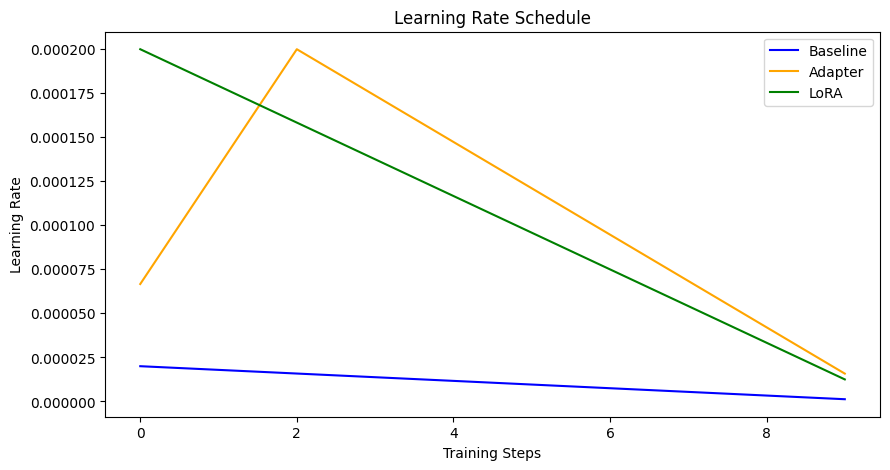

In [34]:
plot_learning_rate_schedule(
    [metrics_callback_baseline.lr_schedule, metrics_callback_adapter.lr_schedule, metrics_callback_lora.lr_schedule, metrics_callback_prefix.lr_schedule],
    ["Baseline", "Adapter", "LoRA", "Prefix"]
)

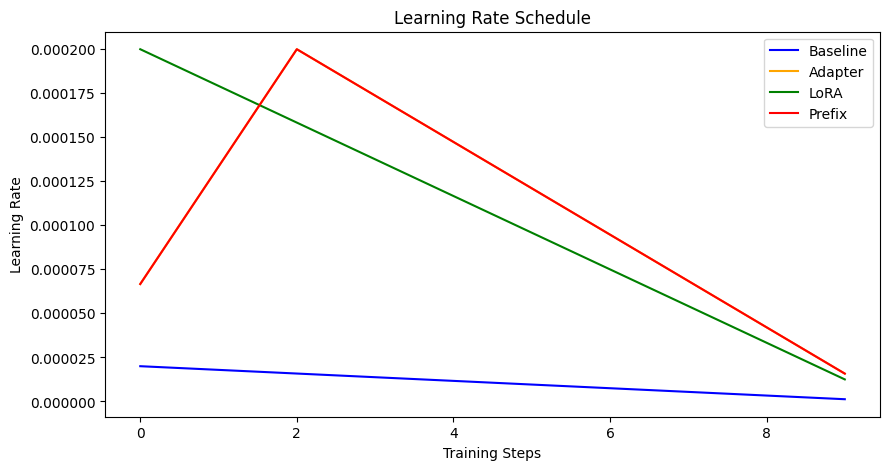

In [39]:
plot_learning_rate_schedule(
    [metrics_callback_baseline.lr_schedule, metrics_callback_adapter.lr_schedule, metrics_callback_lora.lr_schedule, metrics_callback_prefix.lr_schedule],
    ["Baseline", "Adapter", "LoRA", "Prefix"]
)

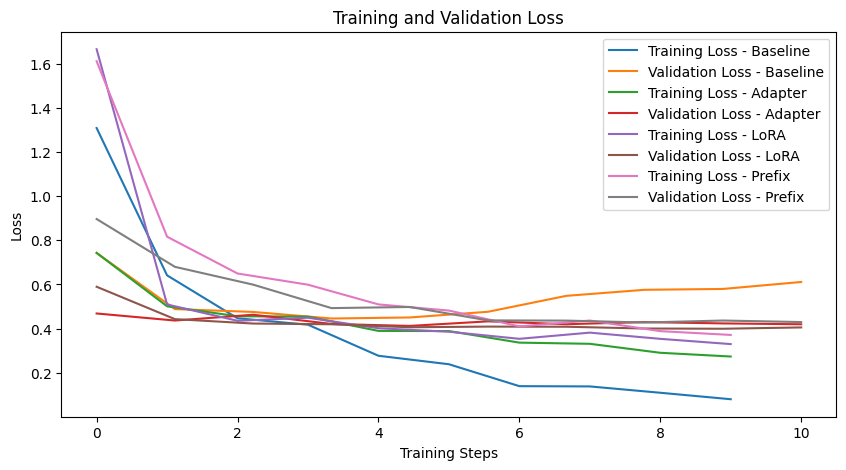

In [40]:
plot_loss_curves(
    [metrics_callback_baseline.train_losses, metrics_callback_adapter.train_losses, metrics_callback_lora.train_losses, metrics_callback_prefix.train_losses],
    [metrics_callback_baseline.eval_losses, metrics_callback_adapter.eval_losses, metrics_callback_lora.eval_losses, metrics_callback_prefix.eval_losses],
    ["Baseline", "Adapter", "LoRA", "Prefix"]
)

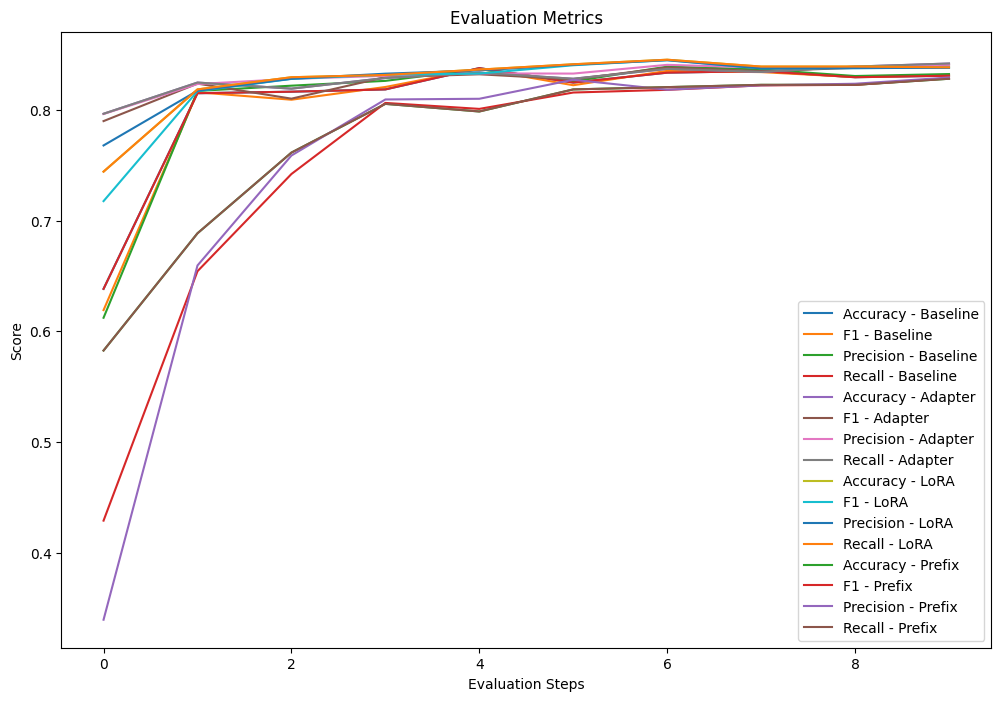

In [41]:
plot_evaluation_metrics(
    [metrics_callback_baseline.eval_metrics, metrics_callback_adapter.eval_metrics, metrics_callback_lora.eval_metrics, metrics_callback_prefix.eval_metrics],
    ["Baseline", "Adapter", "LoRA", "Prefix"]
)

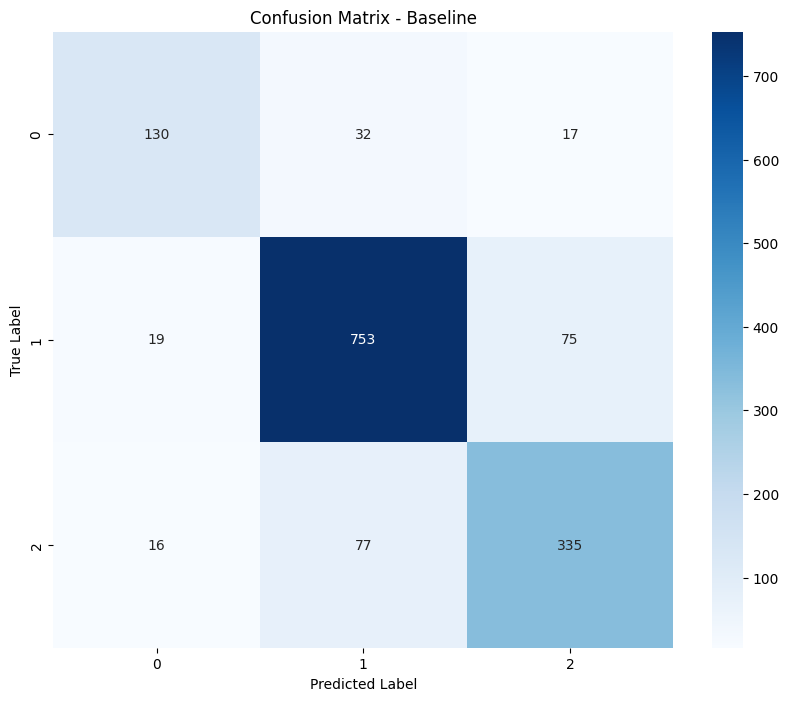

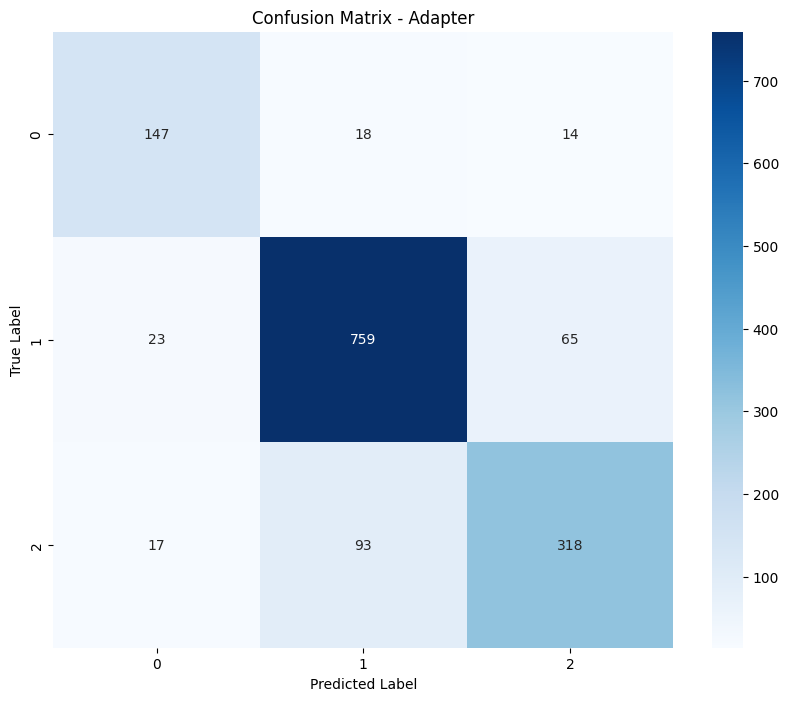

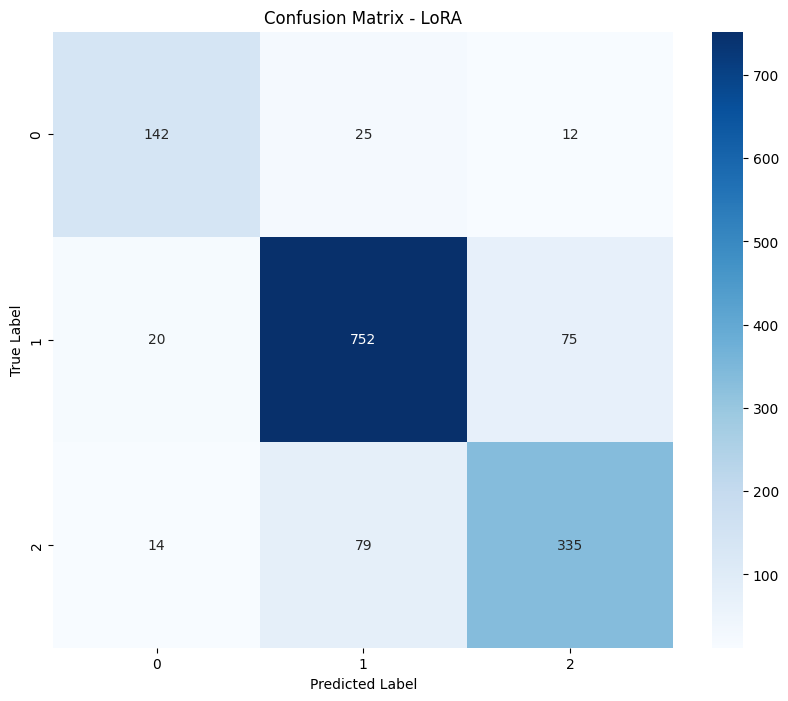

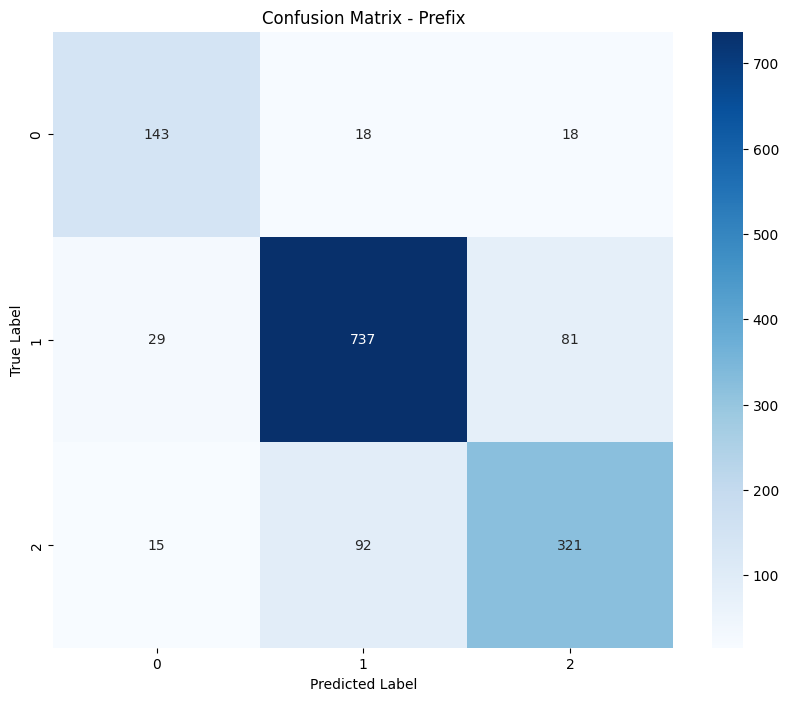

In [42]:
plot_confusion_matrix(
    [y_true_baseline, y_true_adapter, y_true_lora, y_true_prefix],
    [y_pred_baseline, y_pred_adapter, y_pred_lora, y_pred_prefix],
    ["Baseline", "Adapter", "LoRA", "Prefix"]
)

# 8. Final Evaluation Metrics

In [43]:
print("Final Evaluation Metrics - Baseline:")
for metric, value in final_metrics_baseline.items():
    print(f"{metric.capitalize()}: {value:.4f}")

Final Evaluation Metrics - Baseline:
Accuracy: 0.8377
F1: 0.8371
Precision: 0.8368
Recall: 0.8377


In [44]:
print("Final Evaluation Metrics - Adapter:")
for metric, value in final_metrics_adapter.items():
    print(f"{metric.capitalize()}: {value:.4f}")

Final Evaluation Metrics - Adapter:
Accuracy: 0.8418
F1: 0.8408
Precision: 0.8408
Recall: 0.8418


In [45]:
print("Final Evaluation Metrics - LoRA:")
for metric, value in final_metrics_lora.items():
    print(f"{metric.capitalize()}: {value:.4f}")

Final Evaluation Metrics - LoRA:
Accuracy: 0.8453
F1: 0.8450
Precision: 0.8448
Recall: 0.8453


In [46]:
print("Final Evaluation Metrics - Prefix:")
for metric, value in final_metrics_prefix.items():
    print(f"{metric.capitalize()}: {value:.4f}")

Final Evaluation Metrics - Prefix:
Accuracy: 0.8260
F1: 0.8259
Precision: 0.8260
Recall: 0.8260


# 9. Resource Usage Summary

In [ ]:
print("Resource Usage Summary - Baseline:")
print(resource_summary_baseline)